In [1]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam
from backtester.swarms import SwarmManager, SwarmRanker
from backtester.positionsizing import PositionSizingBase
import pandas as pd
import numpy as np
import scipy

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


# Volatility exploration of EXOs

In [47]:
import os
exos_data = {}
for fn in os.listdir('../mat/'):
    if '.mat' not in fn:
        continue
        
    d, info = matlab.loaddata('../mat/'+fn)
    n = info['underlying']+"_"+info['name']
    exos_data[n] = d.exo
    

On this figure we have a several different EXOs, with extremely different volatilities.

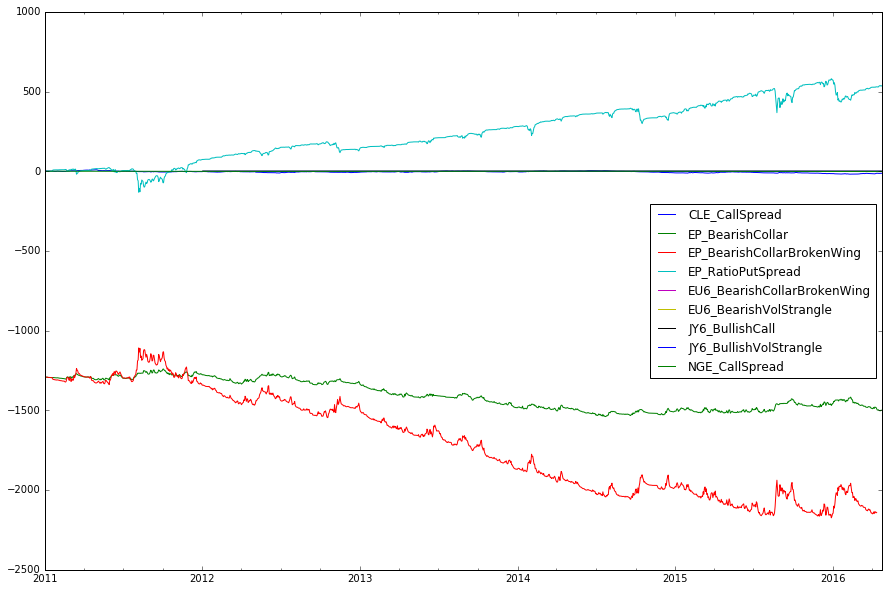

In [52]:
exo_df = pd.DataFrame(exos_data)
exo_df.plot()

#### Descriptive stats for every EXO returns

In [53]:
exo_df.diff().describe()

,CLE_CallSpread,EP_BearishCollar,EP_BearishCollarBrokenWing,EP_RatioPutSpread,EU6_BearishCollarBrokenWing,EU6_BearishVolStrangle,JY6_BullishCall,JY6_BullishVolStrangle,NGE_CallSpread
count,1385.000000,1385.000000,1376.000000,1385.000000,1124.000000,1124.000000,1124.000000,1124.000000,1385.000000
mean,-0.010801,-0.150000,-0.617078,0.387762,0.000186,0.000111,-0.000002,-0.000001,-0.001528
std,0.526653,4.683735,12.980275,7.242107,0.006786,0.003379,0.000032,0.000031,0.041034
min,-2.990000,-20.150000,-57.300000,-71.750000,-0.037900,-0.019700,-0.000234,-0.000176,-0.165000
25%,-0.280000,-2.400000,-6.162500,-0.500000,-0.003600,-0.001150,-0.000015,-0.000010,-0.023000
50%,-0.020000,-0.300000,-1.000000,0.250000,-0.000350,0.000250,-0.000002,0.000002,-0.002000
75%,0.270000,1.800000,4.012500,2.000000,0.003650,0.001650,0.000009,0.000012,0.017000
max,2.100000,19.450000,76.050000,55.000000,0.024450,0.013700,0.000210,0.000153,0.263000


#### Visual comparison of volatility of returns

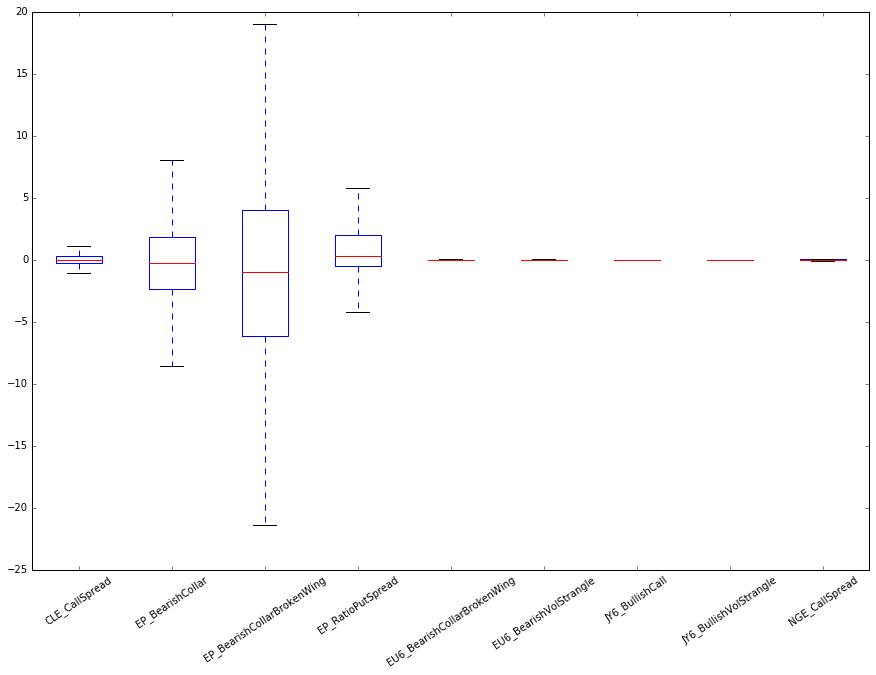

In [71]:
exo_df.diff().plot.box(sym='', rot=34);

# The question: how could we equalize volatility of each EXO

### Linking "R concept" with "Volatility adjusted size"
* I chose median as volatility metric, because it less sensitive to short term volatility bursts than moving average.
* We have only close prices of EXO, that why we are using |exo - exo[-1] | (absolute returns of EXO)

In [158]:
#
# 60 business days rolling window ~~ 1 quarter of time
#
volatility = exo_df.diff().abs().rolling(60).median()

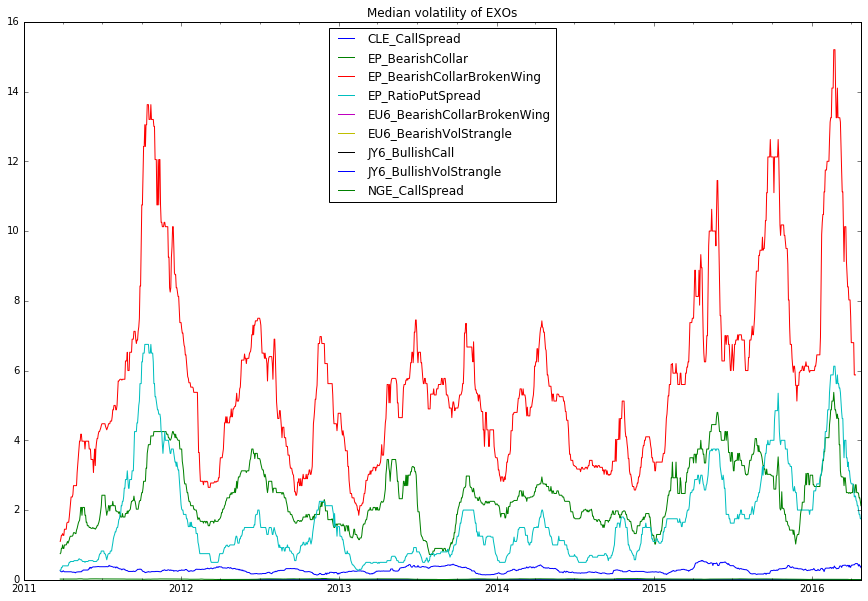

In [157]:
figsize(15,10)
volatility.plot();
title("Median volatility of EXOs")

### Our goal is in implementing risk parity or equal risk across unequally volatile products

Let we want to risk 1000 per single volatiliry unit at trade

Then, our positon should be equal to: [AmmountInDollars] / [VolatilityUnit]

Common sense of R is how many shares of each EXO index we should buy or sell to equalize dollar volatility of each position

In [148]:
R = 1000.0 / volatility

## R-adjusted returns of EXOs analysis

In [149]:
r_adj_exo_df = exo_df.diff() * R

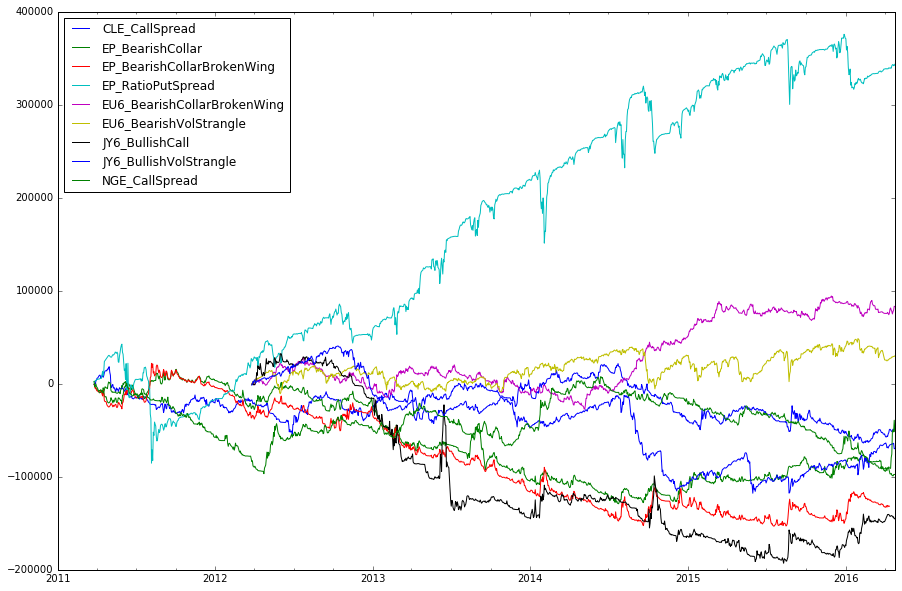

In [150]:
r_adj_exo_df.cumsum().plot()

In [151]:
r_adj_exo_df.describe()

,CLE_CallSpread,EP_BearishCollar,EP_BearishCollarBrokenWing,EP_RatioPutSpread,EU6_BearishCollarBrokenWing,EU6_BearishVolStrangle,JY6_BullishCall,JY6_BullishVolStrangle,NGE_CallSpread
count,1326.000000,1326.000000,1317.000000,1326.000000,1065.000000,1065.000000,1065.000000,1065.000000,1326.000000
mean,-36.941328,-73.567104,-99.892474,259.080261,78.101264,28.127589,-136.261734,-65.459689,-38.737701
std,2117.108777,2199.662484,2486.270584,4936.665582,1833.257539,2288.855883,3813.114849,2327.285695,2250.146247
min,-13288.888889,-9353.846154,-9921.397380,-47833.333333,-7277.108434,-12301.886792,-44571.428571,-16230.769231,-12181.818182
25%,-1011.194030,-1084.643659,-1179.245283,-479.047619,-965.517241,-812.500000,-1151.515152,-790.123457,-1094.319776
50%,-82.553191,-170.476559,-208.333333,222.222222,-97.297297,181.818182,-177.777778,208.333333,-100.000000
75%,985.187180,892.270594,769.230769,1363.636364,1023.809524,1034.482759,765.957447,972.222222,829.268293
max,10848.484848,11111.111111,14214.953271,30428.571429,9061.224490,9309.090909,33333.333333,9837.837838,24400.000000


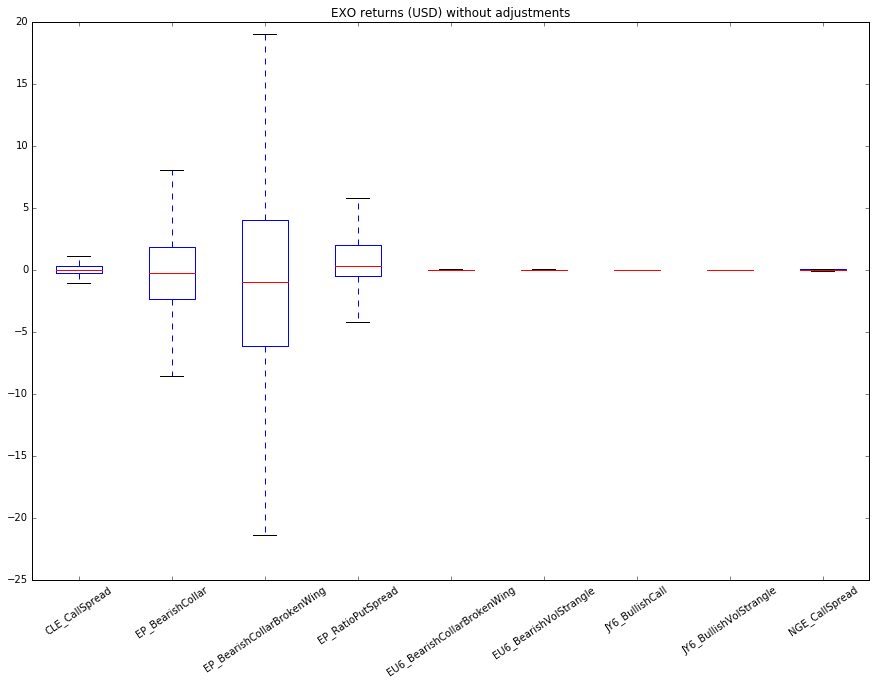

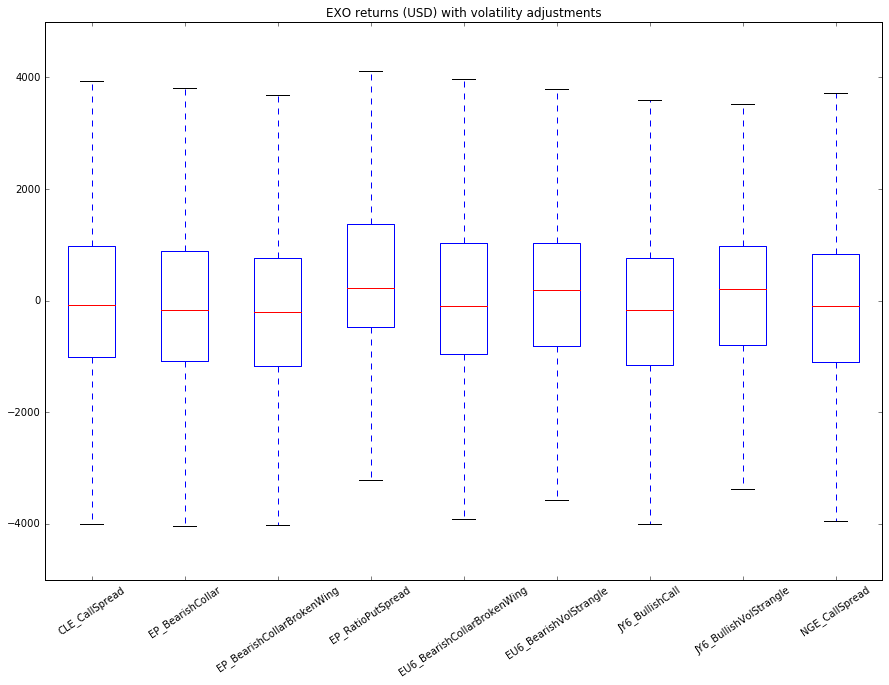

In [179]:
exo_df.diff().plot.box(sym='', rot=34, title='EXO returns (USD) without adjustments');
r_adj_exo_df.plot.box(sym='', rot=34, title='EXO returns (USD) with volatility adjustments');


## Pitfalls of volatility adjustment method

#### Managing low volatility periods

In my experience, volatility adjustment method has one serious issue. When the volatility of an asset is abnormally low the position size is tending to be higher than usual. In that case we have a probability of substantial loss if volatility returns to normal or high values.

We can manage this problem if we include lower bound constraints in volatility formula calculations.

In [155]:
v = exo_df.diff().abs()
#
# let our lower bound constraints is 100-period 30% percintile of vola
#
vol_contraints = v.rolling(200).quantile(0.4)

volatility_with_constraints = volatility.apply( lambda x: np.maximum(x, vol_contraints[x.name] ) )

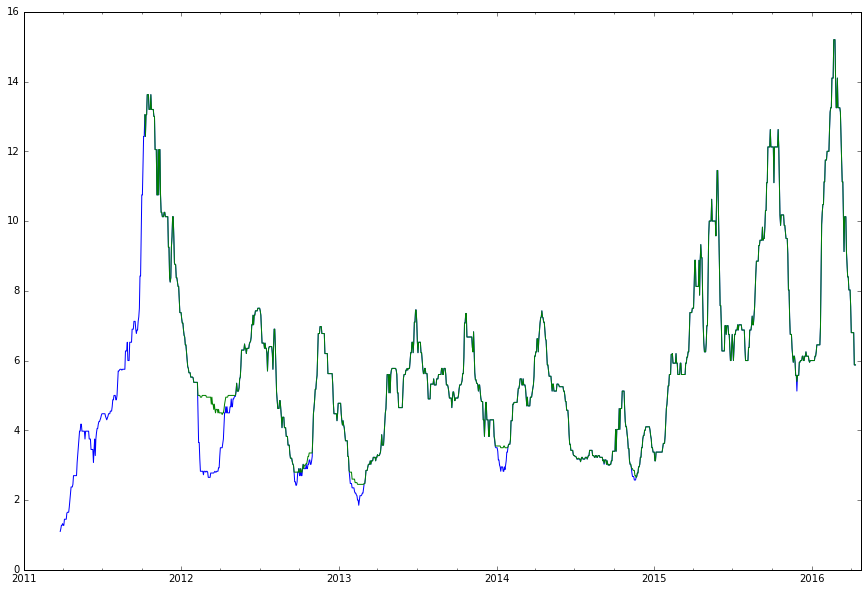

In [156]:
volatility.EP_BearishCollarBrokenWing.plot()
volatility_with_constraints.EP_BearishCollarBrokenWing.plot()

## Expressing results as R


In fact in the formula R = 1000.0 / volatility, R is not a result of its calculation, but 1000.0 USD value. Which means that we willing to risk about 1000.0 USD per volatility unit.

Thats why we could express trading systems backtesting results as Rs factors

In [159]:
strategyname = 'strategy_270225'
d, info = matlab.loaddata('../mat/'+strategyname+'.mat')

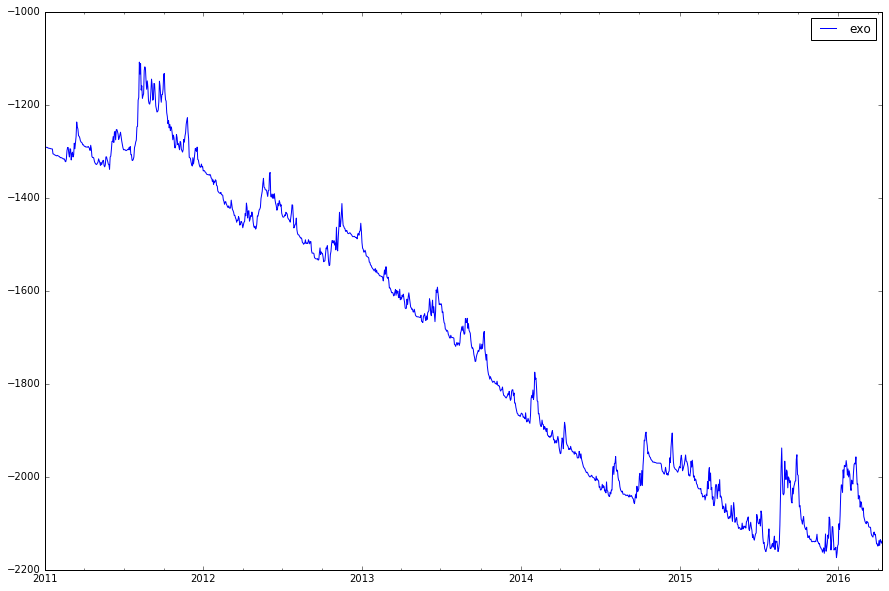

In [160]:
d.plot()


In [161]:
info

{'legs': 4,
 'name': 'BearishCollarBrokenWing',
 'pcf': array([1, 2, 0, 1], dtype=uint8),
 'pcfqty': array([-1, -1,  1,  1], dtype=int16),
 'tickincrement': 0.25,
 'tickvalue': 12.5,
 'underlying': 'EP'}

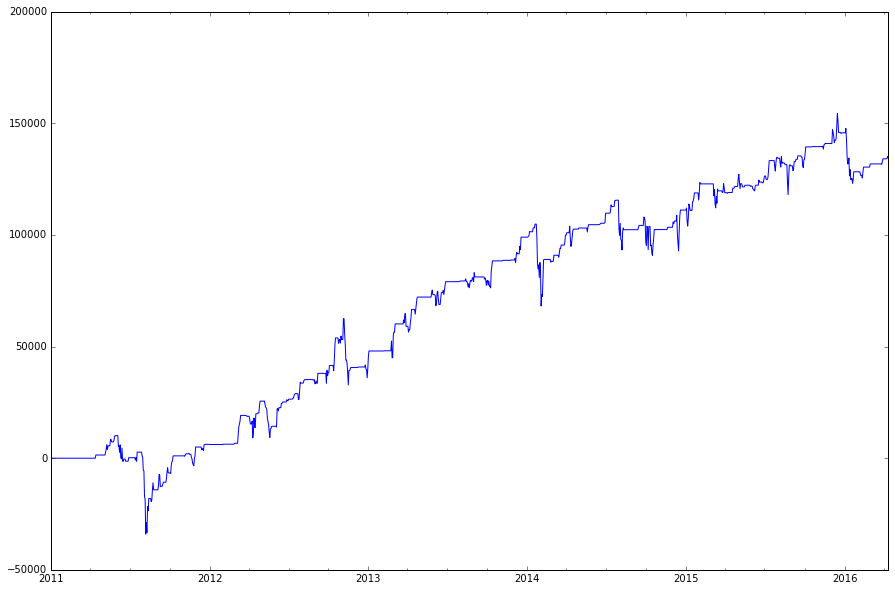

In [165]:
# Position size
# Volatility adjusted
volatility = d.exo.diff().abs().rolling(60).median()
R = 1000.0 
size = R / volatility


slow_ma = d.exo.rolling(5).mean()
fast_ma = d.exo.rolling(6).mean()

short_entry = CrossDown(fast_ma, slow_ma)
short_exit = (CrossUp(fast_ma, slow_ma)) 

direction = -1
pl, inposition = backtester.backtest(d, short_entry, short_exit, direction )
equity, stats = backtester.stats(pl, inposition, positionsize=size)

#X axis, initial equity curve
#Colored blue
x=equity
x.plot()

## Common USD stats

In [172]:
pd.Series(stats)

avg                 1187.006110
avgbarsintrade         3.592920
avgmae             -2995.913011
count                113.000000
maxdd             -44140.796837
netprofit         134131.690479
std                 5075.683194
tradesmaxdd       -28202.335299
winrate                0.734513
dtype: float64

## R stats

#### Our net profit is 134.1R and our MaxDrawDown is -44R, Average trade is 1.19R

In [174]:
(pd.Series(stats) / R).round(2)

avg                 1.19
avgbarsintrade      0.00
avgmae             -3.00
count               0.11
maxdd             -44.14
netprofit         134.13
std                 5.08
tradesmaxdd       -28.20
winrate             0.00
dtype: float64

### R Equity

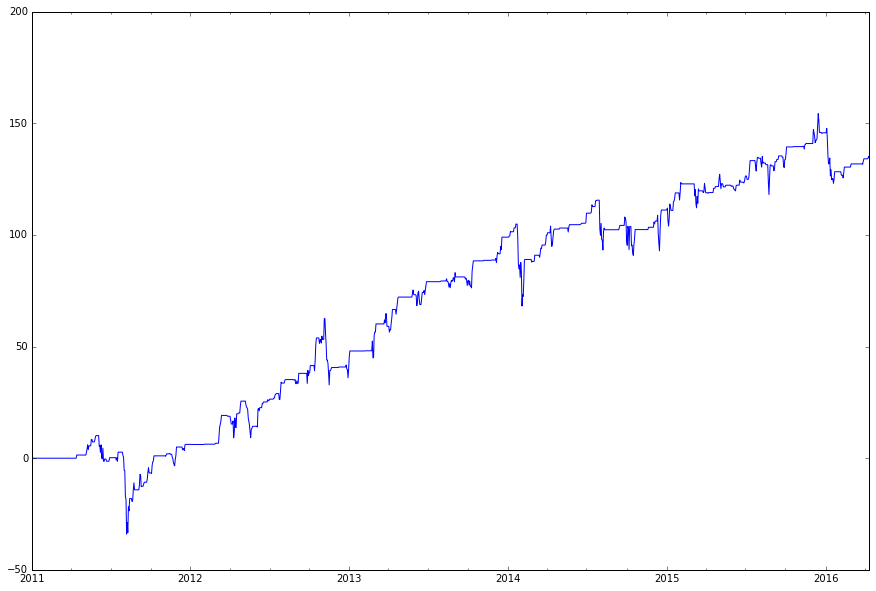

In [176]:
(equity / R).round(2).plot()